### Old Code

Mistake corrected here: **radd function was still doing other + self causing a never ending recursion to the same function**

In [ ]:
from typing import Tuple, Optional, List
from __future__ import annotations
import math

class Value:
    '''Lowest unit of this activity. Represents a value, on which we will do operations, differentiation etc.
       I need to keep track of: Value, operation that created it, parents that led to its creation, differentiation function?
    '''
    def __init__(self, data: float, name: Optional[str] = '', _op: str = None, _parents: Tuple['Value'] = ()) -> None:
        self.data = data
        self._backward = lambda : None
        self._op = _op
        self._parents = _parents
        self.name = name
        self.grad = 0.0

    def __repr__(self) -> str:
        '''way to recreate the value object, meant for developers'''
        return f'Value(data={self.data}, name={self.name}, op={self._op})'

    def __add__(self, other: Value) -> Value:
        '''a+b, where a and b are Value objects, a.__add__(b) called'''
        if isinstance(other, (int, float)):
            other = Value(other)
        out = Value(self.data + other.data, _op='+', _parents=(self, other))
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other: Value) -> Value:
        '''a*b, where a and b are Value objects, a.__mul__(b) called'''
        if isinstance(other, (int, float)):
            other = Value(other)
        
        out = Value(self.data * other.data, _op='*', _parents=(self, other))
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        '''when b*a called, where b is a scalar, a.__rmul__(b) called.'''
        return self * other
    
    def __radd__(self, other):
        '''when b+a called, where b is a scalar, a.__radd__(b) called.'''
        return self + other
    
    def __pow__(self, other: float):
        '''when we call a ** b, a.__pow__(b) is called, where b is a scalar.'''
        if not isinstance(other, (int, float)):
            raise ValueError("Trying to calculate exp on an incompatible data type. Only supporting int and float.")
        out = Value(self.data ** other, _op=f'**{other}', _parents=(self, ))
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        pass

    def tanh(self):
        x = (2 * self).exp()
        out = (x - 1) / (x + 1)
        return out
    
    def exp(self):
        '''calling exponent on a.exp() is equivalent to e raised to a'''
        out = Value(math.exp(self.data), _op='exp', _parents=(self, ))
        def _backward():
            self.grad += math.exp(self.data) * out.grad
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        '''when we call a / b on 2 value objects, a.__truediv__(b) is called.'''
        out = self * (other ** -1)
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def backward(self):
        ordering = []
        visited = []
        def topological_traversal(e):
            if e not in visited:
                visited.append(e)
                if e._parents:
                    for parent in e._parents:
                        topological_traversal(parent)
                ordering.append(e)
        topological_traversal(self)
        self.grad = 1.0
        for node in reversed(ordering):
            node._backward()

In [2]:
from graphviz import Digraph

def traverse(current: Value, nodes=None, edges=None):
    '''traverse to build nodes and edges for computational graph'''
    if nodes is None:
        nodes = []
    if edges is None:
        edges = []
    if current not in nodes:
        nodes.append(current)
        for parent in current._parents:
            edges.append((parent, current))
            traverse(parent, nodes, edges)
    return nodes, edges


def build_graph(current: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges= traverse(current)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f'{n.name} | data: {n.data: .3f} | grad: {n.grad: .3f}', shape='record')

        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for node1, node2 in edges:
        dot.edge(str(id(node1)), str(id(node2))+node2._op)

    return dot

## NN From Scratch Continued:

8. Implement till step 7 in Pytorch
9. Build Neuron
10. Build Layer
11. Build Neural Networks
12. SGD
13. Training
14. Training with an actual dataset

### Implement till step 7 in Pytorch

In [9]:
import torch

In [15]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.tensor([1.0]).double(); w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

In [20]:
o.data.item()
o.backward()

In [21]:
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [22]:
x1 = Value(2.0, 'x1')
x2 = Value(0.0, 'x2')
w1 = Value(-3.0, 'w1')
w2 = Value(1.0, name='w2')
b = Value(6.8813735870195432, name='b')
n = w1*x1 + w2*x2 + b
o = n.tanh()

In [23]:
print(o)

Value(data=0.7071067811865477, name=, op=*)


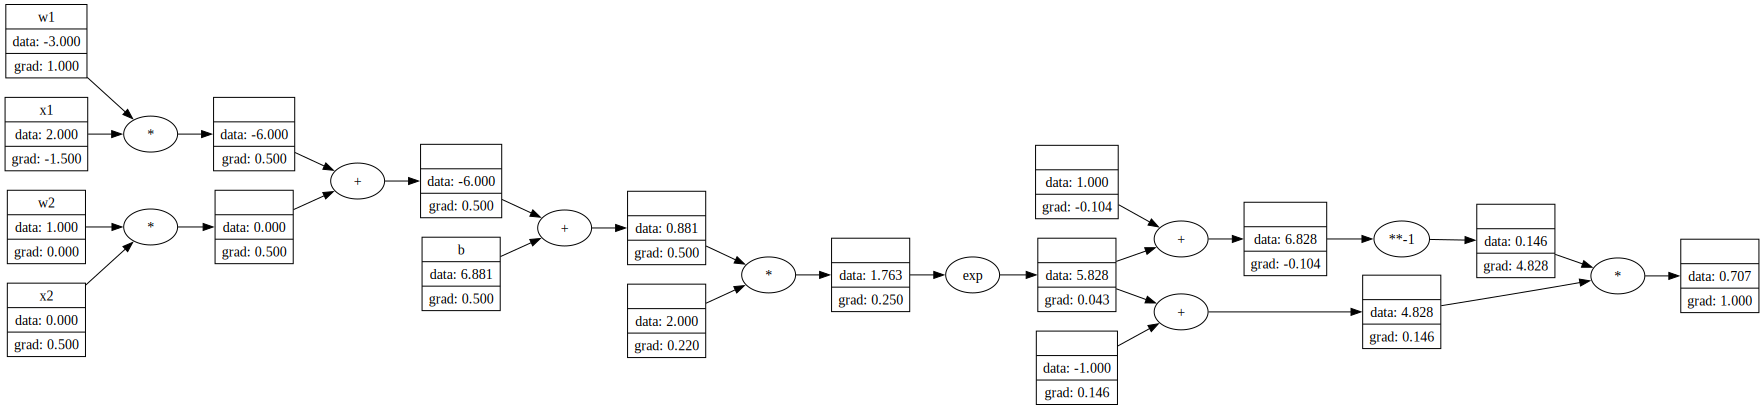

In [26]:
build_graph(o)

In [25]:
o.backward()

### Build Neuron

In [3]:
from abc import ABC, abstractmethod
import random

class Module(ABC):
    @abstractmethod
    def get_parameters(self) -> List:
        return []

    @abstractmethod
    def zero_grad(self) -> None:
        for param in self.get_parameters():
            param.grad = 0

class Neuron(Module):
    '''Contains weights and biases'''
    def __init__(self, n_inputs: int) -> None:
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.bias = Value(random.uniform(-1, 1))

    def __call__(self, x):
        assert len(x) == len(self.weights), f"Expecting input of shape {len(self.weights)} but got {len(x)}"
        act = sum(wi * xi for wi, xi in zip(self.weights, x)) + self.bias
        out = act.tanh()
        return out
    
    def get_parameters(self) -> List:
        return self.weights + [self.bias]
    
    def zero_grad(self):
        return super().zero_grad()

In [4]:
class Layer(Module): 
    '''Collection of neurons form a layer in a network'''
    def __init__(self, n_inputs: int, n_outputs: int) -> None:
        '''Define a collection of neurons
        
        Args:
            n_inputs: Number of inputs to each neuron
            n_outputs: Number of outputs i.e. number of neurons since there is 1 output per neuron
        '''
        self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]
    
    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    
    def get_parameters(self):
        return [param for neuron in self.neurons for param in neuron.get_parameters()]
    
    def zero_grad(self):
        return super().zero_grad()

In [5]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.9146626197887872, name=, op=*),
 Value(data=0.9809791677493143, name=, op=*),
 Value(data=0.24479687273881323, name=, op=*)]

In [6]:
class MLP(Module):
    def __init__(self, n_inputs: float, n_outputs: List[float]):
        n_neurons = [n_inputs] + n_outputs
        self.layers = [Layer(n_neurons[i], n_neurons[i+1]) for i in range(len(n_outputs))]

    def __call__(self, x):
        '''One forward pass through the network with a set of inputs?'''
        for layer in self.layers:
            x = layer(x)
        return x
    
    def get_parameters(self) -> List:
        return [param for layer in self.layers for param in layer.get_parameters()]

    def zero_grad(self):
        return super().zero_grad()            

In [7]:
class StochasticGradientDescent:
    def __init__(self):
        pass

    def step():
        pass


from dataclasses import dataclass

@dataclass
class LearningRate:
    learning_rate: float = 0.0


class LRScheduler(ABC):
    @abstractmethod
    def step(self):
        return []

class LRScheduler():
    pass

class Loss:
    pass



In [ ]:
x = [
    [0.5, 0.7, -1.0, 1.0],
    [0.1, 0.4, 1.0, -1.0],
    [0.3, 0.7, -1.0, 0.9],
    [0.1, 0.2, 1.0, -1.0]
]

y_true = [1.0, -1.0, 1.0, -1.0]
nn = MLP(4, [3, 3, 1])
learning_rate = 0.01

from tqdm import tqdm
for _ in range(20):
    ypred = [nn(xa) for xa in x]
    squared_error_loss = sum((pred - true)**2 for true, pred  in zip(y_true, ypred))
    parameter_list = nn.get_parameters()
    squared_error_loss.backward()

    for parameter in parameter_list:
        parameter.data -= 0.01 * parameter.grad

    print('*'*20)
    print('Loss', squared_error_loss)
    print('\n')
    print(ypred)

********************
Loss Value(data=4.668712994838599, name=, op=+)


[Value(data=-0.47043124677301085, name=, op=*), Value(data=-0.5652963089123721, name=, op=*), Value(data=-0.46762704478567024, name=, op=*), Value(data=-0.5954650797265574, name=, op=*)]
********************
Loss Value(data=4.41123095276922, name=, op=+)


[Value(data=-0.41492491888722544, name=, op=*), Value(data=-0.5278973871915165, name=, op=*), Value(data=-0.4124982629597451, name=, op=*), Value(data=-0.562751550264265, name=, op=*)]
********************
Loss Value(data=3.8998618336087514, name=, op=+)


[Value(data=-0.29294679359072573, name=, op=*), Value(data=-0.44864371995298535, name=, op=*), Value(data=-0.29164865045640453, name=, op=*), Value(data=-0.49423282156798737, name=, op=*)]
********************
Loss Value(data=3.210902428588767, name=, op=+)


[Value(data=-0.09143010808656198, name=, op=*), Value(data=-0.32583742024399986, name=, op=*), Value(data=-0.09263486818560597, name=, op=*), Value(data=-0